# **Importing modules**

In [ ]:
import os # For handling the files
import pickle # Storing numpy features
import numpy as np # To do numerical operations
from tqdm.notebook import tqdm #To see how much images processed

from tensorflow.keras.preprocessing.image import load_img, img_to_array # To preprocess the image
from tensorflow.keras.preprocessing.text import Tokenizer # To preprocess the text
from tensorflow.keras.preprocessing.sequence import pad_sequences # To preprocess the sequence
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model # To get a representation of the model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add # NN layers
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import matplotlib.pyplot as plt

# **Mount google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import RestNet50 Model**

In [ ]:
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import plot_model
from PIL import UnidentifiedImageError

# Load ResNet50 model
model = ResNet50()
# Restructure the model to remove the final prediction layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# Summarize the model
print(model.summary())

102967424/102967424 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                       

### Plot the model

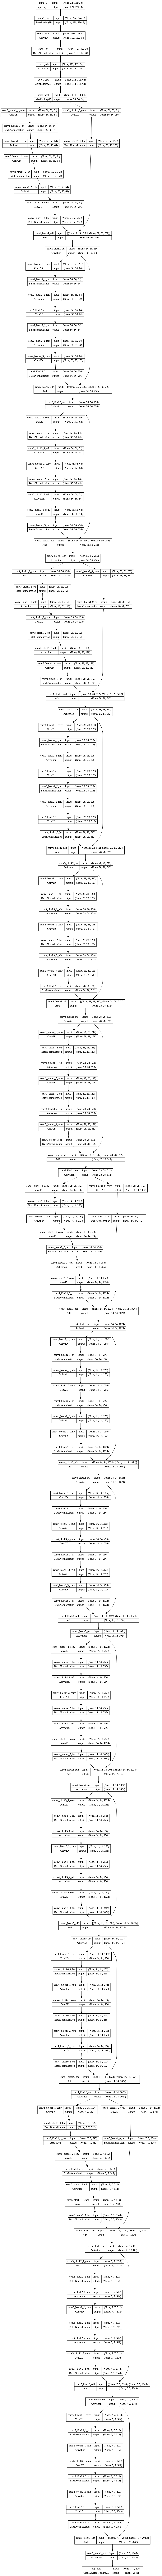

In [ ]:
# Plot the model to visualize the architecture
plot_model(model, show_shapes=True)

# **Extracting Image Features**

In [ ]:
# Image data directory
imgDir = '/content/drive/MyDrive/Deep_Learning/Dataset/Image caption generator Dataset/Images'
# Dictionary to store features
imgFeatures = {}
# Directory to the images
directory = os.path.join(imgDir)

for imgName in tqdm(os.listdir(directory)):
    # Image path to load the image
    imgPath = os.path.join(directory, imgName)
    try:
        # Load the image from file
        image = load_img(imgPath, target_size=(224, 224))
        # Convert image pixels to numpy array
        image = img_to_array(image)
        # Reshape data for model (3 dimension RGB)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # Preprocess image for ResNet50
        image = preprocess_input(image)
        # Extract features
        feature = model.predict(image, verbose=0)
        # Get image ID
        imgId = imgName.split('.')[0]
        # Store feature
        imgFeatures[imgId] = feature
    except (UnidentifiedImageError, OSError) as e:
        # Print out the error and skip the file
        print(f"Error processing {imgName}: {e}")

print(f"Extracted features for {len(imgFeatures)} images.")


In [ ]:
len(imgFeatures)

8090

# **Saving Image Features to Google Drive**

In [ ]:
# Directry to save image features
featureSaveDir = '/content/drive/MyDrive/Deep_Learning/Model_02/Extracted_Features'
# Save features to drive (write binary)
pickle.dump(imgFeatures, open(os.path.join(saveDir, 'features.pkl'), 'wb'))

# **Loading Image Features from Google Drive**

In [ ]:
# Directry to save image features
featureSaveDir = '/content/drive/MyDrive/Deep_Learning/Model_02/Extracted_Features'
# load features from saved directory (read binary)
with open(os.path.join(featureSaveDir, 'features.pkl'), 'rb') as featureFile:
    imgFeatures = pickle.load(featureFile)

In [ ]:
len(imgFeatures)

8090

In [ ]:
imgFeatures

{'2901880865_3fd7b66a45': array([[0.22749072, 0.17396858, 0.13749048, ..., 0.10663293, 0.6842468 ,
         0.19557029]], dtype=float32),
 '576075451_5e0f6facb3': array([[0.6524595 , 0.6878687 , 0.11864151, ..., 0.31064346, 0.08980042,
         0.19730906]], dtype=float32),
 '190965502_0b9ed331d9': array([[0.03037951, 0.05659553, 0.23666489, ..., 0.        , 0.        ,
         0.5127776 ]], dtype=float32),
 '1517807181_ca6588f2a0': array([[1.0417509 , 0.62482345, 0.07179473, ..., 0.9262402 , 1.0890145 ,
         0.10570984]], dtype=float32),
 '468918320_9c275b877f': array([[0.10782744, 0.42956653, 0.02767859, ..., 0.513923  , 0.02087257,
         0.90564185]], dtype=float32),
 '3490736665_38710f4b91': array([[1.0377986 , 1.5354742 , 1.3364117 , ..., 4.584255  , 1.7470877 ,
         0.56150794]], dtype=float32),
 '3278777548_290b881018': array([[0.28127316, 0.        , 0.13119315, ..., 0.8099869 , 0.        ,
         0.        ]], dtype=float32),
 '2056042552_f59e338533': array([[0.1

# **Load Caption Data**

In [ ]:
captionDir = '/content/drive/MyDrive/Deep_Learning/Dataset/Image caption generator Dataset/captions.txt'
with open(os.path.join(captionDir), 'r') as captionFile:
    # to skip first line (images , captions)
    next(captionFile)
    # read all captions
    captionsText = captionFile.read()

In [ ]:
# to see few captions
captionsText[:1000]

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

# **Seperate Captions for Each Image**

In [ ]:
# create mapping of image to captions
mappingImgToCaption = {}
# go through the lines and split
for line in tqdm(captionsText.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    # ignore error texts
    if len(line) < 2:
        continue
    imageId, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    imageId = imageId.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if image has more thatn 1 caption
    if imageId not in mappingImgToCaption:
        mappingImgToCaption[imageId] = []
    # store the caption
    mappingImgToCaption[imageId].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 721197.38it/s]


In [ ]:
mappingImgToCaption

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [ ]:
len(mappingImgToCaption)

8091

In [ ]:
# to see the number of captions
captionsLength = len(mappingImgToCaption)
captionsLength

8091

#Function for clean the captions

In [ ]:
def cleanCaptions(mappingImgToCaption):
    for key, captions in mappingImgToCaption.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing
            # convert to lowercase
            caption = caption.lower()
            # remove digits, special chars and etc
            caption = caption.replace('[^A-Za-z]', '')
            # remove extra spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startOfCaption ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endOfCaption'
            captions[i] = caption

### Captions of One image

In [ ]:
# all captions of one image
mappingImgToCaption['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

### Clean the captions

In [ ]:
# preprocess the captions
cleanCaptions(mappingImgToCaption)

In [ ]:
# after preprocess of captions
mappingImgToCaption['1000268201_693b08cb0e']

['startOfCaption child in pink dress is climbing up set of stairs in an entry way endOfCaption',
 'startOfCaption girl going into wooden building endOfCaption',
 'startOfCaption little girl climbing into wooden playhouse endOfCaption',
 'startOfCaption little girl climbing the stairs to her playhouse endOfCaption',
 'startOfCaption little girl in pink dress going into wooden cabin endOfCaption']

### Delete the missed Image

In [ ]:
del mappingImgToCaption['2387197355_237f6f41ee']

### Check if the image deleted

In [ ]:
len(mappingImgToCaption)

8090

### List All Captions

In [ ]:
# list for all captions
allCaptions = []
# store all captions in list
for key in mappingImgToCaption:
    for caption in mappingImgToCaption[key]:
        allCaptions.append(caption)

In [ ]:
# number of captions
len(allCaptions)

40450

In [ ]:
# first 10 captions
allCaptions[:10]

['startOfCaption child in pink dress is climbing up set of stairs in an entry way endOfCaption',
 'startOfCaption girl going into wooden building endOfCaption',
 'startOfCaption little girl climbing into wooden playhouse endOfCaption',
 'startOfCaption little girl climbing the stairs to her playhouse endOfCaption',
 'startOfCaption little girl in pink dress going into wooden cabin endOfCaption',
 'startOfCaption black dog and spotted dog are fighting endOfCaption',
 'startOfCaption black dog and tri-colored dog playing with each other on the road endOfCaption',
 'startOfCaption black dog and white dog with brown spots are staring at each other in the street endOfCaption',
 'startOfCaption two dogs of different breeds looking at each other on the road endOfCaption',
 'startOfCaption two dogs on pavement moving toward each other endOfCaption']

### Tokenize the words

In [ ]:
# tokenize the text (getting words of captions)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(allCaptions)
vocabularySize = len(tokenizer.word_index) + 1

In [ ]:
vocabularySize

8483

### Get the Length of Longest Caption

In [ ]:
# get maximum length of the caption available
maxLength = max(len(caption.split()) for caption in allCaptions)
maxLength

35

### Train Test Split

In [ ]:
imageIds = list(mappingImgToCaption.keys())
# 90% data for training
# 10% data for testing
DataSplit = int(len(imageIds) * 0.90)
train = imageIds[:DataSplit]
print("train :" + str(len(train)))
test = imageIds[DataSplit:]
print("test :" + str(len(test)))

train :7281
test :809


In [ ]:
train[:10]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615',
 '1007320043_627395c3d8',
 '1009434119_febe49276a',
 '1012212859_01547e3f17',
 '1015118661_980735411b',
 '1015584366_dfcec3c85a']

# **Function to Generate data to Input**

In [ ]:
# create data generator to get data in batch (avoids session crash)
def dataGenerator(dataKeys, mappingImgToCaption, features, tokenizer, maxLength, vocabularySize, batchSize):
    # loop over images
    imgFeatures, inSequence, outSequence = list(), list(), list()
    n = 0
    while 1:
        for key in dataKeys:
            n += 1
            captions = mappingImgToCaption[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    inputSeqence, outputSeq = seq[:i], seq[i]
                    # pad input sequence
                    inputSeqence = pad_sequences([inputSeqence], maxlen=maxLength)[0]
                    # encode output sequence
                    outputSeq = to_categorical([outputSeq], num_classes=vocabularySize)[0]

                    # store the sequences
                    imgFeatures.append(features[key][0])
                    inSequence.append(inputSeqence)
                    outSequence.append(outputSeq)
            if n == batchSize:
                # convert lists to numpy arrays
                imgFeatures, inSequence, outSequence = np.array(imgFeatures), np.array(inSequence), np.array(outSequence)
                yield {"image": imgFeatures, "text": inSequence}, outSequence
                imgFeatures, inSequence, outSequence = list(), list(), list()
                n = 0

# **Model Creation**

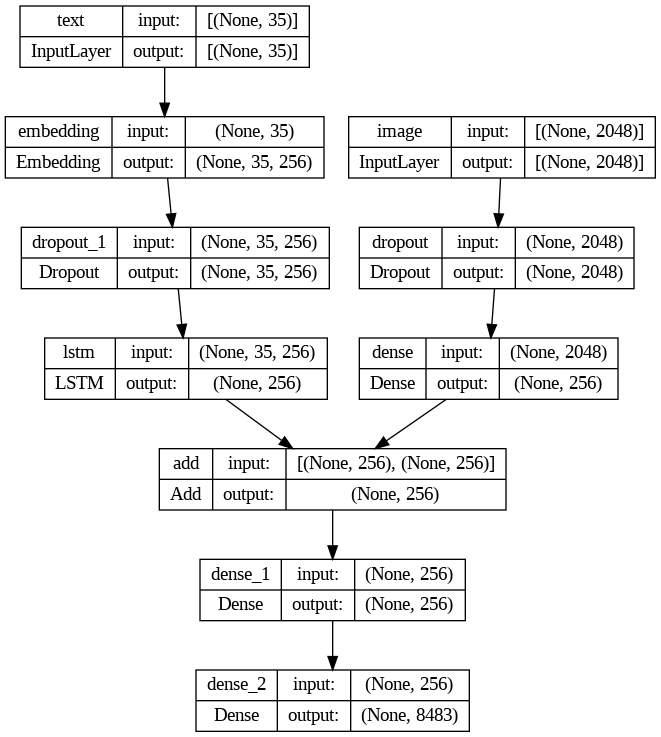

In [ ]:
# modeling encoder
# image feature layers
input1 = Input(shape=(2048,), name="image")
firstEncoder1 = Dropout(0.4)(input1)
firstEncoder2 = Dense(256, activation='relu')(firstEncoder1)
# sequence feature layers
input2 = Input(shape=(maxLength,), name="text")
secondEncoder1 = Embedding(vocabularySize, 256, mask_zero=True)(input2)
secondEncoder2 = Dropout(0.4)(secondEncoder1)
secondEncoder3 = LSTM(256)(secondEncoder2)

# modeling decoder
decoder1 = add([firstEncoder2, secondEncoder3])
decoder2 = Dense(256, activation='relu')(decoder1)
output = Dense(vocabularySize, activation='softmax')(decoder2)

model = Model(inputs=[input1, input2], outputs=output)
# model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# plot the model
plot_model(model, show_shapes=True)

# **Train the Model**

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Directory to save the model checkpoints
checkpoint_dir = '/content/drive/MyDrive/Deep_Learning/ModelCheckpoints_Model02'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.keras'),
    save_weights_only=False,  # Save the model architecture along with weights
    save_freq='epoch',  # Save after each epoch
    verbose=1  # Enable verbose output for saving
)

# Set parameters
epochs = 100
batchSize = 64
steps = len(train) // batchSize

# Create data generator
generator = dataGenerator(train, mappingImgToCaption, imgFeatures, tokenizer, maxLength, vocabularySize, batchSize)

# Fit the model for the entire number of epochs, using the checkpoint callback
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 5.6533 - accuracy: 0.1200
Epoch 1: saving model to /content/drive/MyDrive/Deep_Learning/ModelCheckpoints_Model02/model_epoch_01.keras
113/113 [==============================] - 60s 449ms/step - loss: 5.6533 - accuracy: 0.1200
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 4.5156 - accuracy: 0.2054
Epoch 2: saving model to /content/drive/MyDrive/Deep_Learning/ModelCheckpoints_Model02/model_epoch_02.keras
113/113 [==============================] - 48s 424ms/step - loss: 4.5156 - accuracy: 0.2054
Epoch 3/100
113/113 [==============================] - ETA: 0s - loss: 3.8856 - accuracy: 0.2662
Epoch 3: saving model to /content/drive/MyDrive/Deep_Learning/ModelCheckpoints_Model02/model_epoch_03.keras
113/113 [==============================] - 45s 401ms/step - loss: 3.8856 - accuracy: 0.2662
Epoch 4/100
113/113 [==============================] - ETA: 0s - loss: 3.6095 - accuracy: 0.2861
Epoch 4: sav

# **Load the Model**

In [ ]:
import tensorflow as tf

# Specify the path to the saved model file
model_path = '/content/drive/MyDrive/Deep_Learning/ModelCheckpoints/model_epoch_50.keras'

# Load the model
model = tf.keras.models.load_model(model_path)

# Verify the model summary to ensure it has been loaded correctly
model.summary()

# **Save the Best Model**

In [ ]:
modelSaveDir = '/content/drive/MyDrive/Deep_Learning/'
model.save(saveDir+'/bestModel.h5')

# **Generate Captions**



---


### Function for convert index to word

In [ ]:
def indexToWord(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

### Function for Predict Captions

In [ ]:
# generate caption for an image
def predictCaption(model, image, tokenizer, maxLength):
    # add start tag for generation process
    inputText = 'startOfCaption'
    # iterate over the max length of sequence
    for i in range(maxLength):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([inputText])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], maxLength)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = indexToWord(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        inputText += " " + word
        # stop when reach end tag
        if word == 'endofcaption':
            break

    return inputText

# Evaluating using **BLEU**

In [ ]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mappingImgToCaption[key]
    # predict the caption for image
    prediction = predictCaption(model, imgFeatures[key], tokenizer, maxLength)
    # split into words
    actualCaptions = [caption.split() for caption in captions]
    prediction = prediction.split()
    # append to the list
    actual.append(actualCaptions)
    predicted.append(prediction)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 809/809 [33:37<00:00,  2.49s/it]


BLEU-1: 0.158632
BLEU-2: 0.089538


### Function to Generate captions

In [ ]:
def generateCaption(imageName):
    dataDir= "/content/drive/MyDrive/Deep_Learning/Dataset/Image caption generator Dataset/"
    # load a image
    # imageName = "1001773457_577c3a7d70.jpg"
    imageId = imageName.split('.')[0]
    imgPath = os.path.join(dataDir, "Images", imageName)
    image = Image.open(imgPath)
    captions = mappingImgToCaption[imageId]
    print('Actual: ')
    for caption in captions:
        print(caption)
    # predict the caption
    prediction = predictCaption(model, imgFeatures[imageId], tokenizer, maxLength)
    print('Predicted:')
    print(prediction)
    plt.imshow(image)

# Generate Captions for few Images


---



Actual: 
startOfCaption black dog and spotted dog are fighting endOfCaption
startOfCaption black dog and tri-colored dog playing with each other on the road endOfCaption
startOfCaption black dog and white dog with brown spots are staring at each other in the street endOfCaption
startOfCaption two dogs of different breeds looking at each other on the road endOfCaption
startOfCaption two dogs on pavement moving toward each other endOfCaption
Predicted:
startOfCaption black and white dog with spotted dog is jumping on the sidewalk endofcaption


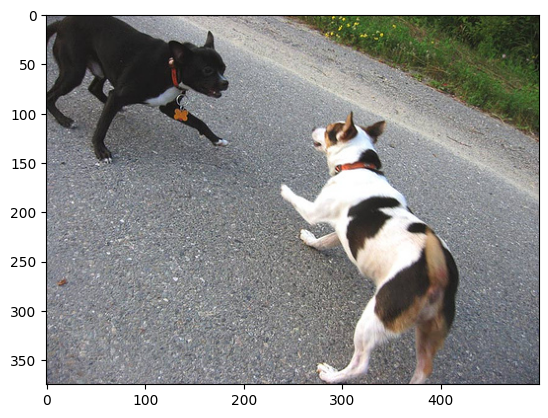

In [ ]:
generateCaption("1001773457_577c3a7d70.jpg")

Actual: 
startOfCaption brown and white dog is running through the snow endOfCaption
startOfCaption dog is running in the snow endOfCaption
startOfCaption dog running through snow endOfCaption
startOfCaption white and brown dog is running through snow covered field endOfCaption
startOfCaption the white and brown dog is running over the surface of the snow endOfCaption
Predicted:
startOfCaption dog with red collar is running through the snow endofcaption


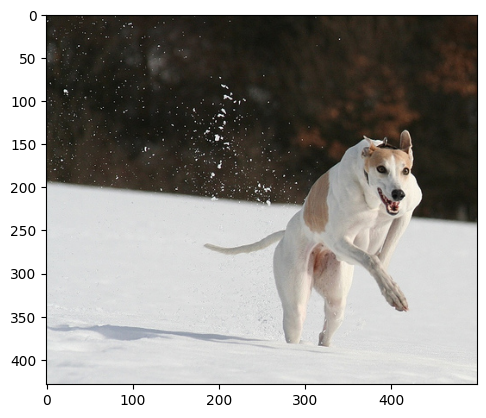

In [ ]:
generateCaption("101654506_8eb26cfb60.jpg")

Actual: 
startOfCaption brown dog chases the water from sprinkler on lawn endOfCaption
startOfCaption brown dog plays with the hose endOfCaption
startOfCaption brown dog running on lawn near garden hose endOfCaption
startOfCaption dog is playing with hose endOfCaption
startOfCaption large brown dog running away from the sprinkler in the grass endOfCaption
Predicted:
startOfCaption dog wearing red cape is running beside the green grass endofcaption


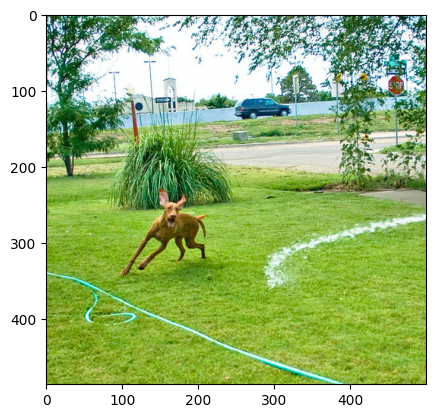

In [ ]:
generateCaption("1019077836_6fc9b15408.jpg")

Actual: 
startOfCaption the children are playing in the water endOfCaption
startOfCaption "two boys one with yellow and orange ball play in some water in front of field ." endOfCaption
startOfCaption two boys play in puddle endOfCaption
startOfCaption two children play with balloon in mud on sunny day endOfCaption
startOfCaption two kids are running and playing in some water endOfCaption
Predicted:
startOfCaption two children are playing in water with water on the horizon endofcaption


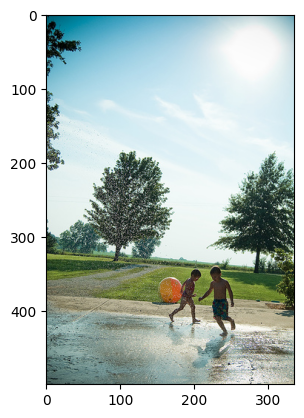

In [ ]:
generateCaption("1056249424_ef2a2e041c.jpg")

Actual: 
startOfCaption black and white dog is attempting to catch yellow and purple object in low cut yard endOfCaption
startOfCaption black and white dog jumps after yellow toy endOfCaption
startOfCaption black and white dog jumps to get the frisbee endOfCaption
startOfCaption black dog is jumping up to catch purple and green toy endOfCaption
startOfCaption dog jumps to catch toy endOfCaption
Predicted:
startOfCaption black and white dog is running with blue toy in its mouth endofcaption


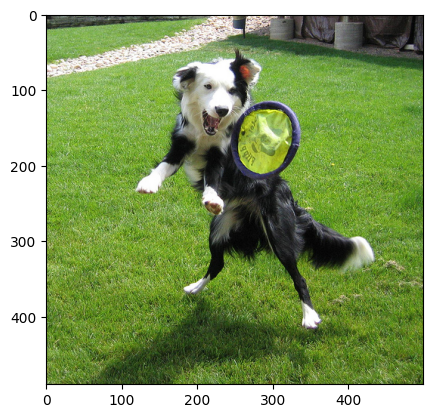

In [ ]:
generateCaption("1067180831_a59dc64344.jpg")

In [ ]:
!pip install nbconvert
!apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package texlive-generic-recommended
